<div style="text-align: center; margin-bottom: 2em;">
<h1 style="font-size: 1.8em;">GPU Resource Partitioning and Bandwidth Analysis on SDumont II HPC Cluster</h1>
</div>

**Abstract:** This report measures CPU-GPU bandwidth and application performance on SDumont II's NVIDIA GH200 nodes, comparing exclusive and shared queue allocation modes. Using nvbandwidth, we measured 411 GB/s host-to-device bandwidth for local GPU access versus 88 GB/s for remote access (4.6x difference). In shared queue mode, SLURM's GRES scheduling maintained NUMA locality. GROMACS benchmarks (STMV, ~1M atoms) showed identical single-GPU performance in both queues (43.45 ns/day). Multi-GPU scaling achieved 2.5x speedup with 4 GPUs; 2-GPU runs showed no benefit due to communication overhead.

**Keywords:** GPU partitioning, NUMA, NVLink, SLURM, HPC, SDumont II, GROMACS

---

## 1. Introduction

### 1.1 Motivation

SDumont II at LNCC offers two allocation modes for NVIDIA GH200 nodes:
- **Exclusive queue**: Full node reserved for one job
- **Shared queue**: SLURM GRES scheduling partitions resources among jobs

This work measures:
1. CPU-GPU bandwidth under different NUMA configurations
2. Whether SLURM preserves NUMA locality in shared mode
3. Application performance differences between queues

### 1.2 GH200 Node Architecture

Each SDumont II node contains four GH200 superchips:
- 72 Arm Neoverse V2 CPU cores per superchip
- 120 GB HBM3 GPU memory per GPU
- NVLink-C2C: 900 GB/s CPU-GPU bandwidth (local)
- NVLink 4.0 between GPUs

### 1.3 NUMA Topology

GPU-NUMA affinity:
- GPU 0 ↔ NUMA 0 (cores 0-71)
- GPU 1 ↔ NUMA 1 (cores 72-143)
- GPU 2 ↔ NUMA 2 (cores 144-215)
- GPU 3 ↔ NUMA 3 (cores 216-287)

---

## 2. Experimental Setup

### 2.1 Hardware Configuration

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re, warnings
from pathlib import Path
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12})
RESULTS_DIR = Path('../../data/transfer')

#### Hardware Specifications

| Component | Specification |
|-----------|---------------|
| Node Type | NVIDIA GH200 Grace Hopper Superchip |
| GPUs per Node | 4x NVIDIA GH200 120GB |
| GPU Memory | 120 GB HBM3 per GPU |
| CPU Cores | 288 (72 per NUMA package) |
| CPU Memory | ~480 GB LPDDR5X (120 GB per package) |
| GPU Interconnect | NVLink 4.0 (NV6 = 6 NVLinks bonded) |
| CUDA Version | 12.6 |
| Driver Version | 560.35.03 |

#### Node Topology

The following diagram illustrates the topology of a GH200 node:

![Node topology diagram](./img/exclusive.png)

Key observations:
- 4 NVIDIA GH200 GPUs per node
- 4 CPU NUMA packages (0-3)
- Each GPU has affinity to one NUMA package
- All GPUs connected via NVLink 4.0 (NV6 = 6 bonded links)

### 2.2 Queue Configurations

| Queue | Type | Description | Max GPUs |
|-------|------|-------------|----------|
| `gh200` | Exclusive | Full node reserved for a single job | 4 |
| `gh200_shared` | Shared | GRES scheduling among multiple jobs | 2 |

### 2.3 Tools and Methodology

| Tool | Version | Purpose |
|------|---------|--------|
| **numactl** | - | NUMA scheduling policy management |
| **nvbandwidth** | v0.6 | CPU-GPU and GPU-GPU bandwidth measurement |
| **nvidia-smi** | 560.35.03 | GPU topology and monitoring |

---

## 3. Experiments

### 3.1 Bandwidth Benchmarks (nvbandwidth)

#### Exclusive Queue
- Pin process to each NUMA (0-3) using `numactl --cpunodebind --membind`
- Measure bandwidth to all 4 GPUs per pinning
- Result: 4×4 bandwidth matrix

#### Shared Queue
- Submit concurrent jobs requesting 1 or 2 GPUs
- Observe SLURM's NUMA-GPU assignment
- Measure bandwidth to allocated GPUs

In [2]:
def parse_h2d_bandwidth(filepath):
    with open(filepath, 'r') as f: content = f.read()
    match = re.search(r'Running host_to_device_memcpy_ce\.\nmemcpy CE CPU\(row\) -> GPU\(column\) bandwidth \(GB/s\)\n\s+[\d\s]+\n\s*0\s+([\d\.\s]+)\n', content)
    return [float(x) for x in match.group(1).strip().split()] if match else None

def parse_d2h_bandwidth(filepath):
    with open(filepath, 'r') as f: content = f.read()
    match = re.search(r'Running device_to_host_memcpy_ce\.\nmemcpy CE CPU\(row\) <- GPU\(column\) bandwidth \(GB/s\)\n\s+[\d\s]+\n\s*0\s+([\d\.\s]+)\n', content)
    return [float(x) for x in match.group(1).strip().split()] if match else None

def parse_latency(filepath):
    with open(filepath, 'r') as f: content = f.read()
    match = re.search(r'Running host_device_latency_sm\.\nmemory latency SM CPU\(row\) <-> GPU\(column\) \(ns\)\n\s+[\d\s]+\n\s*0\s+([\d\.\s]+)\n', content)
    return [float(x) for x in match.group(1).strip().split()] if match else None

def parse_numa_pinning(filepath):
    with open(filepath, 'r') as f: content = f.read()
    match = re.search(r'PINNED to (\d+)', content) or re.search(r'cpubind: (\d+)\s*\n', content)
    return int(match.group(1)) if match else None

In [3]:
exclusive_h2d, exclusive_d2h, exclusive_latency = {}, {}, {}
for i in range(4):
    filepath = RESULTS_DIR / f'exclusive_4gpu_node{i}.txt'
    if filepath.exists():
        numa = parse_numa_pinning(filepath)
        if (h2d := parse_h2d_bandwidth(filepath)): exclusive_h2d[numa] = h2d
        if (d2h := parse_d2h_bandwidth(filepath)): exclusive_d2h[numa] = d2h
        if (lat := parse_latency(filepath)): exclusive_latency[numa] = lat

h2d_df = pd.DataFrame(exclusive_h2d, index=[f'GPU {i}' for i in range(4)]).T
h2d_df.index, h2d_df.columns = [f'NUMA {i}' for i in h2d_df.index], [f'GPU {i}' for i in range(4)]
d2h_df = pd.DataFrame(exclusive_d2h, index=[f'GPU {i}' for i in range(4)]).T
d2h_df.index, d2h_df.columns = [f'NUMA {i}' for i in d2h_df.index], [f'GPU {i}' for i in range(4)]
latency_df = pd.DataFrame(exclusive_latency, index=[f'GPU {i}' for i in range(4)]).T
latency_df.index, latency_df.columns = [f'NUMA {i}' for i in latency_df.index], [f'GPU {i}' for i in range(4)]

local_h2d = [h2d_df.iloc[i, i] for i in range(4)]
remote_h2d = [h2d_df.iloc[i, j] for i in range(4) for j in range(4) if i != j]
local_lat = [latency_df.iloc[i, i] for i in range(4)]
remote_lat = [latency_df.iloc[i, j] for i in range(4) for j in range(4) if i != j]

---

## 4. Results and Discussion

### 4.1 Bandwidth Results

#### 4.1.1 Exclusive Queue - Host-to-Device Bandwidth

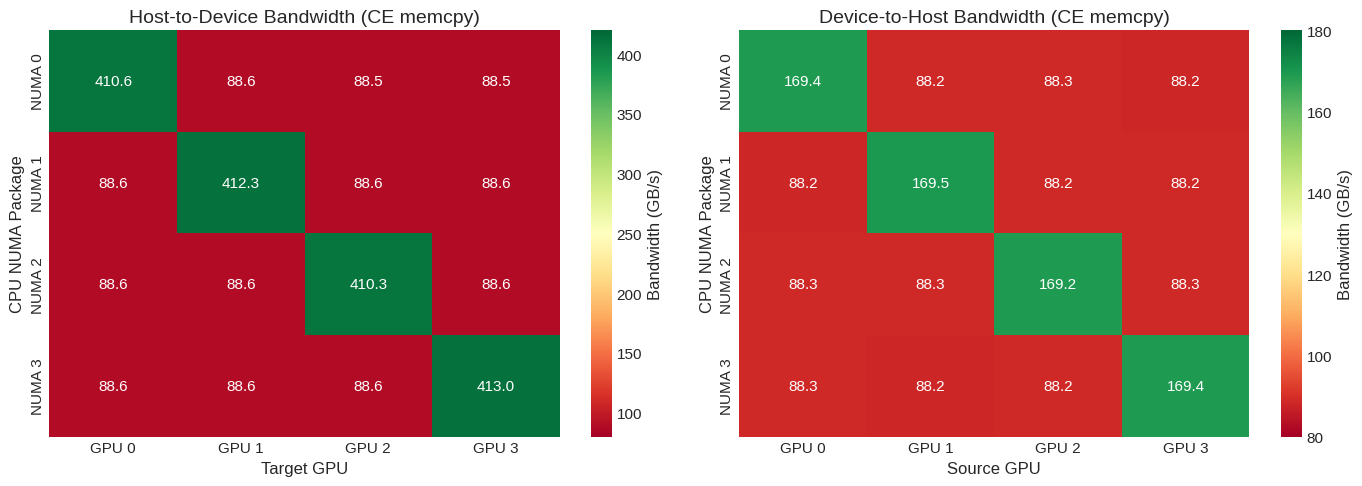

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(h2d_df, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[0], vmin=80, vmax=420, cbar_kws={'label': 'Bandwidth (GB/s)'})
axes[0].set_title('Host-to-Device Bandwidth (CE memcpy)'); axes[0].set_xlabel('Target GPU'); axes[0].set_ylabel('CPU NUMA Package')
sns.heatmap(d2h_df, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[1], vmin=80, vmax=180, cbar_kws={'label': 'Bandwidth (GB/s)'})
axes[1].set_title('Device-to-Host Bandwidth (CE memcpy)'); axes[1].set_xlabel('Source GPU'); axes[1].set_ylabel('CPU NUMA Package')
plt.tight_layout(); plt.savefig('img/bandwidth_heatmaps.png', dpi=150, bbox_inches='tight'); plt.show()

**Result:** Local GPU access (diagonal) achieves ~410 GB/s; remote access (off-diagonal) achieves ~88 GB/s. This 4.6x difference reflects NVLink-C2C (local) versus inter-socket interconnect (remote).

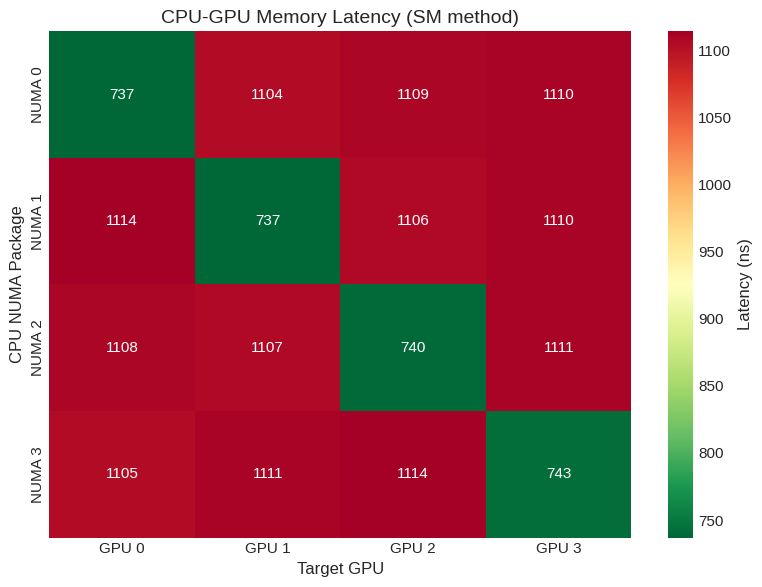

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(latency_df, annot=True, fmt='.0f', cmap='RdYlGn_r', ax=ax, cbar_kws={'label': 'Latency (ns)'})
ax.set_title('CPU-GPU Memory Latency (SM method)'); ax.set_xlabel('Target GPU'); ax.set_ylabel('CPU NUMA Package')
plt.tight_layout(); plt.savefig('img/latency_heatmap.png', dpi=150, bbox_inches='tight'); plt.show()

**Latency:** Local ~737 ns, remote ~1100 ns (1.5x difference).

#### 4.1.2 Shared Queue Performance

In [6]:
def parse_shared_results(filepath):
    with open(filepath, 'r') as f: content = f.read()
    h2d = re.findall(r'Running host_to_device_memcpy_ce\.\nmemcpy CE CPU\(row\) -> GPU\(column\) bandwidth \(GB/s\)\n\s+0\n\s*0\s+([\d\.]+)', content)
    numa = re.findall(r'cpubind: (\d+)\s*\n', content)
    return {'h2d_bandwidth': [float(x) for x in h2d], 'numa_nodes': [int(x) for x in numa]}

shared_1gpu_data = []
for i in range(4):
    filepath = RESULTS_DIR / f'shared_array_1gpu_node{i}.txt'
    if filepath.exists():
        data = parse_shared_results(filepath)
        if data['h2d_bandwidth']:
            shared_1gpu_data.append({'job': i, 'numa': data['numa_nodes'][0] if data['numa_nodes'] else None, 'h2d': data['h2d_bandwidth'][0]})
shared_1gpu_df = pd.DataFrame(shared_1gpu_data)

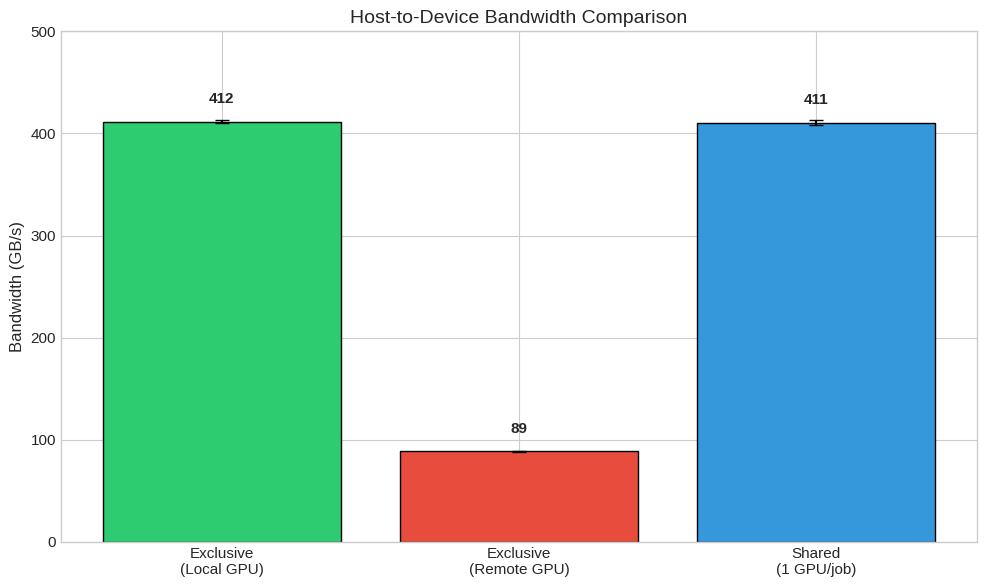

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Exclusive\n(Local GPU)', 'Exclusive\n(Remote GPU)', 'Shared\n(1 GPU/job)']
values = [np.mean(local_h2d), np.mean(remote_h2d), shared_1gpu_df['h2d'].mean() if len(shared_1gpu_df) > 0 else 0]
errors = [np.std(local_h2d), np.std(remote_h2d), shared_1gpu_df['h2d'].std() if len(shared_1gpu_df) > 0 else 0]
bars = ax.bar(categories, values, yerr=errors, capsize=5, color=['#2ecc71', '#e74c3c', '#3498db'], edgecolor='black')
ax.set_ylabel('Bandwidth (GB/s)'); ax.set_title('Host-to-Device Bandwidth Comparison'); ax.set_ylim(0, 500)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15, f'{val:.0f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout(); plt.savefig('img/bandwidth_comparison.png', dpi=150, bbox_inches='tight'); plt.show()

### 4.2 Bandwidth Summary

| Metric | Local | Remote | Ratio |
|--------|-------|--------|-------|
| H2D Bandwidth | 411.6 GB/s | 88.6 GB/s | 4.65x |
| D2H Bandwidth | 169.4 GB/s | 88.3 GB/s | 1.9x |
| Latency | 739 ns | 1109 ns | 1.5x |

In shared mode, SLURM assigned CPUs from the NUMA package with GPU affinity. Shared queue bandwidth matched exclusive local bandwidth.

### 4.3 GROMACS Benchmark

To validate bandwidth findings with a real application, we ran GROMACS molecular dynamics simulations.

**Configuration:**
- System: STMV (~1M atoms)
- GROMACS 2023.2 (NVIDIA container)
- GPU offloading: nb, bonded, pme
- 100,000 steps, performance measured from step 90,000

In [8]:
# GROMACS Results Parser - GPU Scaling
GROMACS_LOGS_DIR = Path('../../data/gromacs/logs')

def parse_gromacs_results():
    """Parse all GROMACS output logs."""
    exclusive_results = []
    shared_results = []
    
    # Parse exclusive queue results
    for filepath in sorted(GROMACS_LOGS_DIR.glob('gromacs_exclusive_*.out')):
        content = filepath.read_text()
        
        # Find GPU sections and their corresponding performance
        gpu_sections = re.findall(r'Running GROMACS with (\d+) GPU', content)
        performances = re.findall(r'Performance:\s+([\d.]+)\s+[\d.]+', content)
        
        # Match GPU counts with performance values
        for i, (num_gpus, perf) in enumerate(zip(gpu_sections, performances)):
            exclusive_results.append({
                'num_gpus': int(num_gpus),
                'performance_ns_day': float(perf),
                'queue': 'exclusive'
            })
    
    # Parse shared queue results
    for filepath in sorted(GROMACS_LOGS_DIR.glob('gromacs_shared_*gpu_*.out')):
        content = filepath.read_text()
        
        # Extract GPU count from filename
        gpu_match = re.search(r'shared_(\d+)gpu', filepath.name)
        num_gpus = int(gpu_match.group(1)) if gpu_match else None
        
        # Get performance
        perf_match = re.findall(r'Performance:\s+([\d.]+)\s+[\d.]+', content)
        if perf_match and num_gpus:
            shared_results.append({
                'num_gpus': num_gpus,
                'performance_ns_day': float(perf_match[-1]),
                'queue': 'shared'
            })
    
    return pd.DataFrame(exclusive_results), pd.DataFrame(shared_results)

gromacs_exclusive_df, gromacs_shared_df = parse_gromacs_results()

print("=== GROMACS GPU Scaling Results ===\n")

if len(gromacs_exclusive_df) > 0:
    print("Exclusive Queue:")
    display(gromacs_exclusive_df)
    print()

if len(gromacs_shared_df) > 0:
    print("Shared Queue:")
    display(gromacs_shared_df)

=== GROMACS GPU Scaling Results ===

Exclusive Queue:


,num_gpus,performance_ns_day,queue
0,1,43.450,exclusive
1,2,42.246,exclusive
2,4,108.752,exclusive



Shared Queue:


,num_gpus,performance_ns_day,queue
0,1,43.449,shared
1,2,42.280,shared


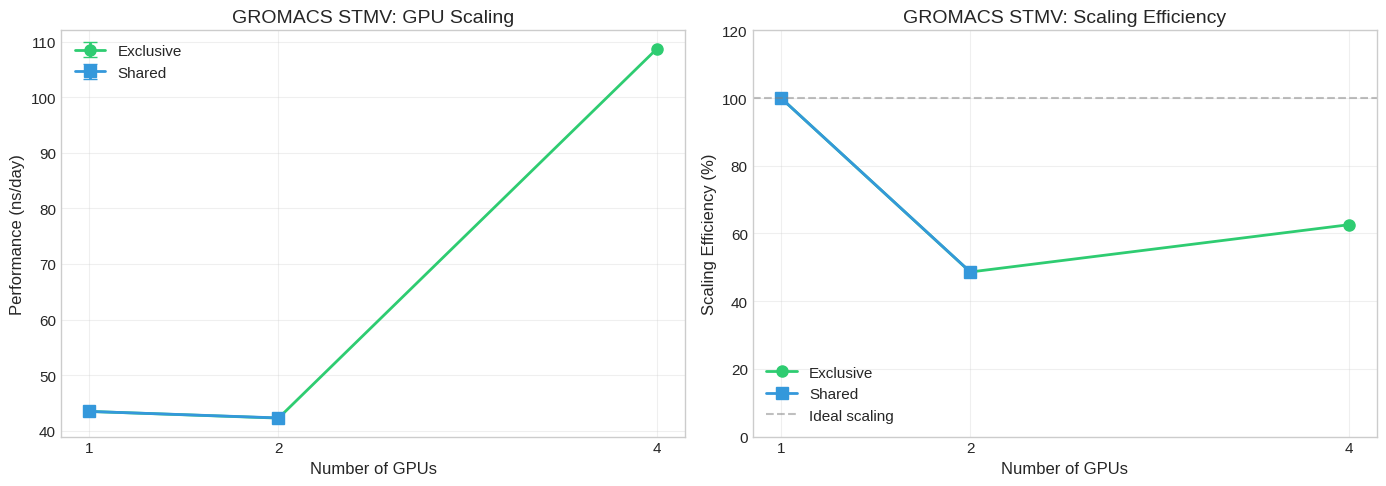

In [9]:
# GROMACS GPU Scaling Comparison Plot
all_results = pd.concat([gromacs_exclusive_df, gromacs_shared_df], ignore_index=True) if len(gromacs_exclusive_df) > 0 or len(gromacs_shared_df) > 0 else pd.DataFrame()

if len(all_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Performance by GPU count
    ax1 = axes[0]
    
    # Group by queue and num_gpus
    for queue, color, marker in [('exclusive', '#2ecc71', 'o'), ('shared', '#3498db', 's')]:
        df = all_results[all_results['queue'] == queue]
        if len(df) > 0:
            grouped = df.groupby('num_gpus')['performance_ns_day'].agg(['mean', 'std'])
            ax1.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                        label=f'{queue.capitalize()}', marker=marker, capsize=5, 
                        linewidth=2, markersize=8, color=color)
    
    ax1.set_xlabel('Number of GPUs')
    ax1.set_ylabel('Performance (ns/day)')
    ax1.set_title('GROMACS STMV: GPU Scaling')
    ax1.legend()
    ax1.set_xticks([1, 2, 4])
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Scaling efficiency (relative to 1 GPU)
    ax2 = axes[1]
    
    for queue, color, marker in [('exclusive', '#2ecc71', 'o'), ('shared', '#3498db', 's')]:
        df = all_results[all_results['queue'] == queue]
        if len(df) > 0:
            grouped = df.groupby('num_gpus')['performance_ns_day'].mean()
            if 1 in grouped.index:
                baseline = grouped[1]
                efficiency = (grouped / baseline) / grouped.index * 100
                ax2.plot(grouped.index, efficiency, marker=marker, label=f'{queue.capitalize()}',
                        linewidth=2, markersize=8, color=color)
    
    ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Ideal scaling')
    ax2.set_xlabel('Number of GPUs')
    ax2.set_ylabel('Scaling Efficiency (%)')
    ax2.set_title('GROMACS STMV: Scaling Efficiency')
    ax2.legend()
    ax2.set_xticks([1, 2, 4])
    ax2.set_ylim(0, 120)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('img/gromacs_scaling.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No GROMACS results available yet. Run the benchmark scripts:")
    print("  sbatch scripts/gromacs/gromacs_exclusive.slurm")
    print("  sbatch scripts/gromacs/gromacs_shared_1gpu.slurm")
    print("  sbatch scripts/gromacs/gromacs_shared_2gpu.slurm")

#### GROMACS Results

| Queue | GPUs | ns/day | Scaling |
|-------|------|--------|---------|
| Exclusive | 1 | 43.45 | 1.00x |
| Exclusive | 2 | 42.25 | 0.97x |
| Exclusive | 4 | 108.75 | 2.50x |
| Shared | 1 | 43.45 | 1.00x |
| Shared | 2 | 42.28 | 0.97x |

**Observations:**
- Single-GPU: Identical performance in both queues
- 2-GPU: Slight performance decrease versus 1-GPU (communication overhead)
- 4-GPU: 2.5x speedup (62.5% efficiency)

In [10]:
summary_data = {
    'Metric': ['H2D Bandwidth (Local)', 'H2D Bandwidth (Remote)', 'D2H Bandwidth (Local)', 
               'D2H Bandwidth (Remote)', 'Latency (Local)', 'Latency (Remote)', 'Local/Remote BW Ratio'],
    'Value': [f'{np.mean(local_h2d):.1f} GB/s', f'{np.mean(remote_h2d):.1f} GB/s',
              f'{np.mean([d2h_df.iloc[i, i] for i in range(4)]):.1f} GB/s',
              f'{np.mean([d2h_df.iloc[i, j] for i in range(4) for j in range(4) if i != j]):.1f} GB/s',
              f'{np.mean(local_lat):.0f} ns', f'{np.mean(remote_lat):.0f} ns', f'{np.mean(local_h2d)/np.mean(remote_h2d):.2f}x']
}
pd.DataFrame(summary_data)

,Metric,Value
0,H2D Bandwidth (Local),411.6 GB/s
1,H2D Bandwidth (Remote),88.6 GB/s
2,D2H Bandwidth (Local),169.4 GB/s
3,D2H Bandwidth (Remote),88.3 GB/s
4,Latency (Local),739 ns
5,Latency (Remote),1109 ns
6,Local/Remote BW Ratio,4.65x


---

## 5. Conclusions

**Bandwidth:**
- Local GPU access: 411 GB/s H2D, 169 GB/s D2H
- Remote GPU access: 88 GB/s (4.6x slower)
- Shared queue maintained NUMA locality

**GROMACS (STMV):**
- Single-GPU: 43.45 ns/day in both queues
- 2-GPU: No scaling benefit
- 4-GPU: 2.5x speedup

**Practical guidance:**
- Single-GPU jobs: Shared queue has no performance penalty
- Multi-GPU GROMACS (STMV): Use 1 or 4 GPUs

---

## 6. References

1. NVIDIA GH200 Grace Hopper Superchip Documentation - https://www.nvidia.com/en-us/data-center/grace-hopper-superchip/
2. SLURM Generic Resource (GRES) Scheduling - https://slurm.schedmd.com/gres.html
3. SDumont II User Manual - https://github.com/lncc-sered/manual-sdumont2nd
4. NVIDIA nvbandwidth Tool - https://github.com/NVIDIA/nvbandwidth
5. NVIDIA GH200 Benchmark Guide - https://docs.nvidia.com/gh200-superchip-benchmark-guide.pdf

---

## Appendix: Scripts and Data

**Bandwidth scripts** (`scripts/transfer/`): `exclusive.slurm`, `shared_array_1gpu.slurm`, `shared_array_2gpu.slurm`

**GROMACS scripts** (`scripts/gromacs/`): `gromacs_exclusive.slurm`, `gromacs_shared_1gpu.slurm`, `gromacs_shared_2gpu.slurm`

**Data** (`data/`): Raw benchmark outputs in `transfer/` and `gromacs/logs/`